# Visualize evidence for model genes

For best results: 
1. Run the [AggregateData_Proteomics](./data/AggregateData_Proteomics.ipynb) notebook first to create a table of reviewed proteins detected across published proteomic studies.
2. Ensure model annotations are updated for following MIRIAM fields:
    * uniprot
    * hgnc.symbol
    * ncbigene
3. Ensure the evidence table columns for proteomic evidence of genes is updated by running the [EvidenceTables_RBC-GEM](./EvidenceTables_RBC-GEM.ipynb) notebook.


## Setup
### Import packages

In [1]:
from collections import defaultdict
import re
import pandas as pd

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from rbc_gem_utils import (
    ROOT_PATH,
    EXTERNAL_PATH,
    INTERIM_PATH,
    CURATION_PATH,
    RESULTS_PATH,
    read_rbc_model,
    get_annotation_df,
    compare_tables,
    visualize_comparison,
    build_string,
    split_string,
    show_versions,
)

# Display versions of last time notebook ran and worked
show_versions()
plt.rcParams["font.family"] = "Arial"


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Load RBC-GEM model

In [2]:
model = read_rbc_model(filetype="xml")
model

Name,RBC_GEM
Memory address,14b0a27d0
Number of metabolites,1984
Number of reactions,2823
Number of genes,693
Number of groups,76
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


In [3]:
# Turned into an xlsx where keys are sheet names and values are DataFrames representing the sheet
all_figure_data = {}
save_figures = True
imagetype = "png"
transparent = True

## Load protein evidence tables

In [4]:
df_evidence = pd.read_csv(
    f"{ROOT_PATH}{CURATION_PATH}/genes_evidence.tsv",
    sep="\t",
    index_col=0,
    dtype=str,
).fillna("")
all_figure_data["GeneEvidenceModel"] = df_evidence.copy()
df_evidence

,genes,uniprot,ncbigene,hgnc.symbol,proteomic evidence (#studies),proteomic evidence (pubmed),references,notes
0,GAPDH,P04406,2597,GAPDH,25,pubmed:12362340;pubmed:14963112;pubmed:1686133...,pubmed:19430704,
1,CAT,P04040,847,CAT,24,pubmed:12362340;pubmed:14963112;pubmed:1686133...,pubmed:16748387;pubmed:901548,
2,HSPA8,P11142,3312,HSPA8,23,pubmed:12362340;pubmed:14963112;pubmed:1686133...,pubmed:33832207,
3,ARG1,P05089,383,ARG1,22,pubmed:12362340;pubmed:14963112;pubmed:1686133...,pubmed:13689647;pubmed:2085183;pubmed:5450162,
4,CA1,P00915,759,CA1,22,pubmed:14963112;pubmed:16861337;pubmed:1849451...,pubmed:10090333;pubmed:4958988;pubmed:4975695,
...,...,...,...,...,...,...,...,...
688,SMPD1,P17405,6609,SMPD1,0,,pubmed:25075126,
689,SPHK1,Q9NYA1,8877,SPHK1,0,,pubmed:26014962;pubmed:33334894;pubmed:33441957,
690,TRPC6,Q9Y210,7225,TRPC6,0,,pubmed:18209485,
691,TSPO2,Q5TGU0,222642,TSPO2,0,,pubmed:27641616;pubmed:30061676;pubmed:31989647,


In [5]:
df_protein_table = pd.read_csv(
    f"{ROOT_PATH}{EXTERNAL_PATH}/proteomics/proteomic_evidence_table.tsv",
    sep="\t",
    index_col=0,
    dtype=str,
)
df_protein_table.columns.name = "pubmed"
df_protein_table = df_protein_table.rename({col: col.lstrip('pubmed:') for col in df_protein_table.columns}, axis=1)
all_figure_data["ProteomicEvidenceAll"] = df_protein_table.copy()
df_protein_table

pubmed,12362340,14963112,16861337,18399644,18494517,18614565,19778645,22157974,22954596,23781972,...,28689405,30327373,31552303,33103907,33341364,33806028,35858567,36346805,37760001,37942280
Uniprot,,,,,,,,,,,,,,,,,,,,,
P04406,1,1,1,1,1,1,1,0,1,1,...,1,1,0,1,1,1,1,1,1,1
P04040,1,1,1,1,1,1,1,0,1,1,...,1,1,0,1,1,1,1,1,1,1
P11142,1,1,1,1,1,1,0,0,1,1,...,1,1,0,1,1,1,1,1,1,1
P02549,1,1,1,1,0,1,1,0,1,0,...,1,1,0,1,1,1,1,1,1,1
P05089,1,1,1,0,0,1,1,0,1,0,...,1,1,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q15751,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Q15738,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Q15717,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Create proteomic evidence table for figure
#### Sorted by publication year (original)

In [6]:
model_uniprot_ids = list(df_evidence["uniprot"].unique())
df_model_proteins = df_protein_table[df_protein_table.index.isin(model_uniprot_ids)].copy()
for protein in df_model_proteins.index.symmetric_difference(model_uniprot_ids):
    # Proteins with no evidence should be given 0 values across studies.
    df_model_proteins.loc[protein, :] = 0

df_model_proteins = df_model_proteins.astype(int)

# Order by number of times a single  protein was detected across studies
protein_ids_ordered = df_model_proteins.sum(axis=1).sort_values(ascending=False).index.values
df_model_proteins = df_model_proteins.loc[protein_ids_ordered, :]

# Transport for figure
df_model_proteins = df_model_proteins.T
df_model_proteins

Uniprot,P04406,P04040,P11142,P05089,P00915,P69905,P11166,P51148,P30043,P32119,...,P35354,P34949,P29474,P26045,P22748,P22732,P19634,P19526,P17405,Q9Y694
pubmed,,,,,,,,,,,,,,,,,,,,,
12362340,1,1,1,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
14963112,1,1,1,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
16861337,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
18399644,1,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
18494517,1,1,1,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
18614565,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
19778645,1,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
22157974,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
22954596,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


### Reordered


In [7]:
# Order by number of proteins detected in a single study
df_model_proteins_reordered = df_model_proteins.T.copy()
pubmed_ids_ordered = df_model_proteins_reordered.sum(axis=0).sort_values(ascending=False).index.values
df_model_proteins_reordered = df_model_proteins_reordered.loc[:, pubmed_ids_ordered]
df_model_proteins_reordered = df_model_proteins_reordered.T
df_model_proteins_reordered

Uniprot,P04406,P04040,P11142,P05089,P00915,P69905,P11166,P51148,P30043,P32119,...,P35354,P34949,P29474,P26045,P22748,P22732,P19634,P19526,P17405,Q9Y694
pubmed,,,,,,,,,,,,,,,,,,,,,
28689405,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
30327373,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
28263177,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
35858567,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
33806028,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
24555563,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
37942280,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
26474164,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
18614565,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


### Visualization

In [8]:
compare = True
overwrite = False

fontsize = 12
max_count = 20
min_count = 0

cmin, cmax = (0.05, 1)

edgecolor = "black"
edgewidth = 0.5
bar_size = 0.75
as_percentages = True
cmap = mpl.colormaps.get_cmap("terrain_r")
no_evidence_color = mpl.colors.to_rgba_array("xkcd:white")

df_model = df_model_proteins.copy()
df_model = df_model_proteins_reordered.copy()

all_figure_data["ProteomicEvidenceModel"] = df_model.copy()

df_model

Uniprot,P04406,P04040,P11142,P05089,P00915,P69905,P11166,P51148,P30043,P32119,...,P35354,P34949,P29474,P26045,P22748,P22732,P19634,P19526,P17405,Q9Y694
pubmed,,,,,,,,,,,,,,,,,,,,,
28689405,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
30327373,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
28263177,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
35858567,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
33806028,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
24555563,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
37942280,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
26474164,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
18614565,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
assert max_count  <= len(df_model),"Maximum count must be less than or equal to the total number of studies."
assert min_count  >= 0,"Minimum count must be non-negative."
df_value_counts = df_model_proteins.sum(axis=0).value_counts().sort_index()

value_counts = df_value_counts[df_value_counts.index <= max_count].to_dict()
value_counts[max(value_counts.keys())] += df_value_counts[df_value_counts.index > max_count].sum()
value_counts = {int(k): v for k, v in value_counts.items()}
df_value_counts = pd.Series(value_counts, name="Total")
id_fix_dict = {
    max_count: f"$\geq${str(max_count)}"
}
if min_count:
    value_counts = df_value_counts[df_value_counts.index >= min_count].to_dict()
    value_counts[min(value_counts.keys())] += df_value_counts[df_value_counts.index < min_count].sum()
    value_counts = {int(k): v for k, v in value_counts.items()}
    id_fix_dict[min_count] = f"{str(min_count)}$\geq$"

value_counts = {id_fix_dict.get(k, k): v for k, v in value_counts.items()}


df_additional = df_evidence.loc[:, ["uniprot", "proteomic evidence (#studies)", "references"]].copy()
df_additional = df_additional.drop_duplicates().drop("uniprot", axis=1)
df_additional["references"] = df_additional["references"].apply(lambda x: int(bool(x)))
df_additional = df_additional.groupby("proteomic evidence (#studies)").sum()
df_additional = df_additional["references"].copy()
df_additional.index = df_additional.index.astype(int)
additional_evidence = df_additional[df_additional.index <= max_count].to_dict()
additional_evidence[max(additional_evidence.keys())] += df_additional[df_additional.index > max_count].sum()
additional_evidence = {int(k): v for k, v in additional_evidence.items()}
df_additional = pd.Series(additional_evidence, name="Total")


if min_count:
    additional_evidence = df_additional[df_additional.index >= min_count].to_dict()
    additional_evidence[min(additional_evidence.keys())] += df_additional[df_additional.index < min_count].sum()
    additional_evidence = {int(k): v for k, v in additional_evidence.items()}
additional_evidence = {id_fix_dict.get(k, k): v for k, v in additional_evidence.items()}



df_value_counts = pd.DataFrame([], columns=["Total", "Additional evidence", "Only proteomic evidence"], dtype=str)
for label, total in value_counts.items():
    df_value_counts.loc[label, "Total"] = total
    df_value_counts.loc[label, "Additional evidence"] = additional_evidence[label]
    df_value_counts.loc[label, "Only proteomic evidence"] = total - additional_evidence[label]
df_value_counts.index.name = "Proteomic evidence (#studies)"
df_value_counts.index = df_value_counts.index.astype(str)
all_figure_data["EvidenceSummaryModel"] = df_value_counts.copy()

df_value_counts

,Total,Additional evidence,Only proteomic evidence
Proteomic evidence (#studies),,,
0,85,85,0
1,55,28,27
2,37,24,13
3,32,13,19
4,30,13,17
5,29,14,15
6,33,21,12
7,24,19,5
8,30,17,13


### Add colormap to table

In [10]:
# Add colormap to table
cmap_dict = dict(zip(
    df_value_counts.index,
    cmap(np.linspace(cmin, cmax, len(df_value_counts.index)))
))

df_value_counts_colors = df_value_counts.copy()
df_value_counts_colors["Colors"] = cmap_dict
df_value_counts_colors = df_value_counts_colors.reindex(
    index=df_value_counts_colors.index[::-1]
)

##### Colorbar legend

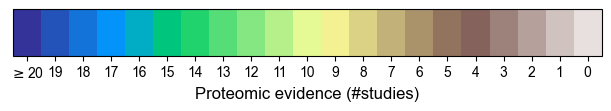

In [11]:
orientation = "horizontal"
figsize = (1 if orientation == 'vertical' else 6, 6 if orientation == 'vertical' else 1)
fig_colorbar, cbar_ax = plt.subplots(figsize=figsize, layout='constrained')

cmap_dict = df_value_counts_colors["Colors"].to_dict()
cmap_segmented = mpl.colors.LinearSegmentedColormap.from_list(
    'legend',
    list(cmap_dict.values()), 
    len(cmap_dict)
)
xticks = list(np.linspace(0, len(cmap_dict) - 1, len(cmap_dict)) + 0.5)
if orientation == "vertical":
    cmap_segmented = cmap_segmented.reversed("legend")
    xticks.reverse()

norm = mpl.colors.BoundaryNorm(
    np.linspace(0, len(cmap_dict), len(cmap_dict) + 1), 
    cmap_segmented.N
)
colorbar = fig_colorbar.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap_segmented),
    cax=cbar_ax,
    orientation=orientation,
    label=df_value_counts_colors.index.name,
)
colorbar.set_ticks(xticks, minor=False, labels=df_value_counts_colors.index, fontsize=fontsize-2)
colorbar.set_ticks([], minor=True)
cbar_ax.set_xlabel(df_value_counts_colors.index.name, fontdict={"size": fontsize});
fig_colorbar;

##### Protein evidence heatmap

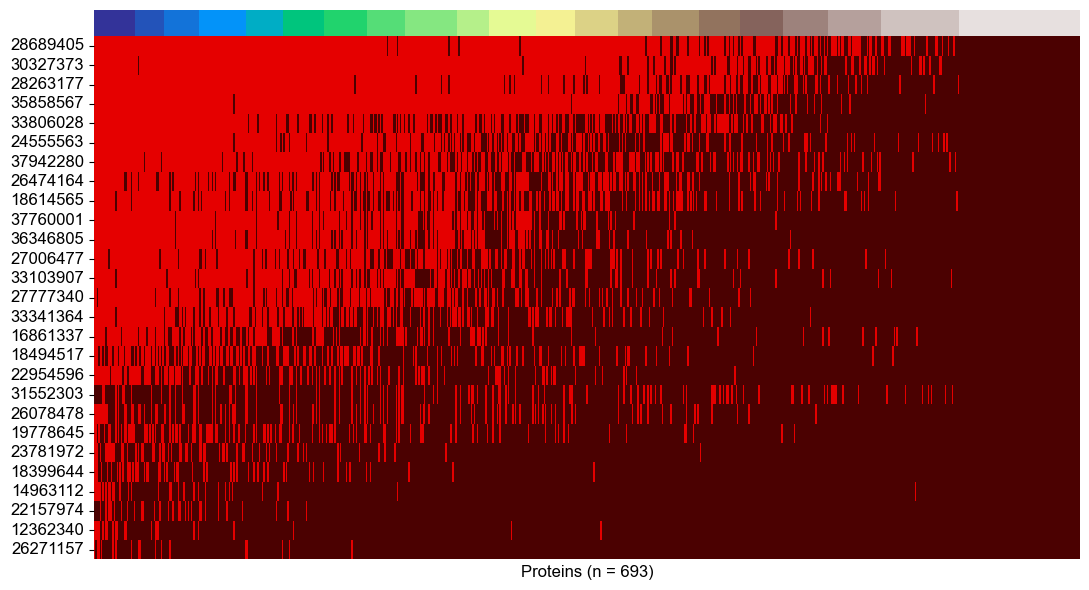

In [12]:
fig = mpl.figure.Figure(figsize=(11, 6))
gs = mpl.gridspec.GridSpec(2, 1, hspace=0, height_ratios=[0.05, 1])

df_proteomic_cmap = df_model.sum()
df_proteomic_cmap = df_proteomic_cmap.apply(
    lambda x: x if x < max_count else max_count
)
df_proteomic_cmap = df_proteomic_cmap.apply(
    lambda x: x if x > min_count else min_count
)

# Add col colors (similar to seaborn)
cmap_dict = df_value_counts_colors["Colors"].to_dict()
cmap_segmented = mpl.colors.LinearSegmentedColormap.from_list(
    "legend",
    [cmap_dict[c] for c in df_value_counts_colors.index[::-1]],
    len(cmap_dict)
)

ax_nstudies_colors = sns.heatmap(
    np.array([df_proteomic_cmap.values]),
    ax=fig.add_subplot(gs[0]),
    xticklabels=False,
    yticklabels=False,
    cmap=cmap_segmented,
    cbar=False,
)


ax_heatmap = sns.heatmap(
    df_model, 
    ax=fig.add_subplot(gs[1]),
    cbar=False, 
    cmap=mpl.colors.ListedColormap(["xkcd:dried blood", "xkcd:red"]),
    xticklabels=False,
)
ax_heatmap.set_xlabel(f"Proteins (n = {len(df_model.columns)})", fontsize=fontsize)
ax_heatmap.set_ylabel(None)
ax_heatmap.yaxis.tick_left()
ax_heatmap.tick_params(axis='y', labelsize=fontsize)

fig.tight_layout()
if save_figures:
    fig.savefig(
        f"{ROOT_PATH}{RESULTS_PATH}/proteomics/ModelProteomicEvidence_PanelA.{imagetype}", 
        transparent=transparent, 
        format=imagetype
    )

fig

#### Barchart

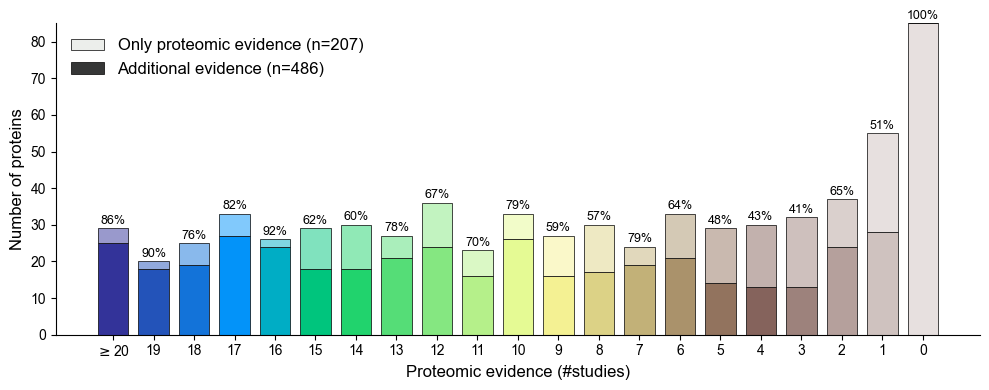

In [13]:
fig, ax_barchart = plt.subplots(1, 1, figsize=(10, 4))
sns.despine(fig)

has_additional_evidence_color, no_additional_evidence_color = (
    mpl.colors.to_rgba_array("xkcd:dark grey"),
    np.array([x/2 + 0.5 for x in mpl.colors.to_rgba_array("xkcd:light grey")]),
)
column_names = ["Additional evidence", "Only proteomic evidence"]
cmaps = dict(zip(column_names, [{}, {}]))

try:
    no_evidence = df_value_counts_colors.loc["0"]["Only proteomic evidence"]
except KeyError as e:
    no_evidence = 0
for key, color in df_value_counts_colors["Colors"].to_dict().items():
    cmaps["Additional evidence"][key] = color
    cmaps["Only proteomic evidence"][key] = [x/2 + 0.5 for x in color]
    if key == "0":
    #     cmaps["Additional evidence"][key] = has_additional_evidence_color
        cmaps["Only proteomic evidence"][key] = no_evidence_color

offset = np.zeros(len(df_value_counts_colors.index))
for idx, (label, series) in enumerate(df_value_counts_colors[column_names].items()):
    rects = ax_barchart.bar(
        list(series.index),
        list(series.values),
        bar_size, 
        label=label,
        color=[cmaps[label][c] for c in series.index],
        bottom=offset,
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += list(series.values)
    if idx == 1:
        labels = [
            f'{v1/v2 * 100:.0f}%' 
            for _, (v1, v2) in df_value_counts_colors[["Additional evidence", "Total"]].iterrows()
        ]
        ax_barchart.bar_label(rects, labels=labels, padding=1, fontsize=fontsize-3)
df_evidence_counts = df_value_counts_colors[column_names].sum(axis=0)
df_evidence_counts["Only proteomic evidence"] -= no_evidence 
handles = [
    mpl.patches.Patch(
        facecolor=facecolor, 
        label=f"{label} (n={n})", 
        edgecolor=edgecolor, 
        linewidth=edgewidth,
    )
    for label, n, facecolor in zip(
        column_names,
        df_evidence_counts.values,
        [has_additional_evidence_color, no_additional_evidence_color]
    )
]
if no_evidence != 0:
    df_evidence_counts["No evidence"] = no_evidence
    handles += [
        mpl.patches.Patch(
            facecolor=no_evidence_color,
            label=f"No evidence (n={no_evidence})",
            edgecolor=edgecolor,
            linewidth=edgewidth
        )
    ]
handles.reverse()
ax_barchart.legend(
    handles=handles, 
    ncol=1,
    loc="best", 
    # bbox_to_anchor=(0.5, 0., 0, 0), 
    frameon=False,
    fontsize=fontsize
)

ax_barchart.set_xlabel(df_value_counts_colors.index.name, fontsize=fontsize)
ax_barchart.set_ylabel(f"Number of proteins", fontsize=fontsize)
fig.tight_layout()
if save_figures:
    fig.savefig(
        f"{ROOT_PATH}{RESULTS_PATH}/proteomics/ModelProteomicEvidence_PanelB.{imagetype}", 
        transparent=transparent, 
        format=imagetype
    )
fig;

#### Pie chart

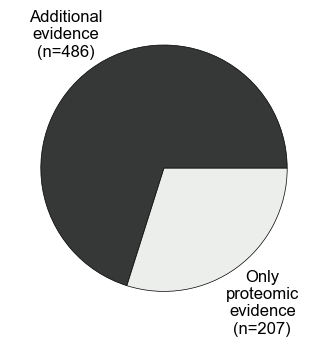

In [14]:
fig, pie_ax = plt.subplots(1, 1, figsize=(4, 4))
df_evidence_counts = df_value_counts_colors[column_names].sum(axis=0)
colors = [has_additional_evidence_color, no_additional_evidence_color]
if no_evidence != 0:
    df_evidence_counts["No evidence"] = no_evidence
    colors += [no_evidence_color]
    
pie_ax.pie(
    df_evidence_counts.values,
    labels=["{}\n(n={})".format(label.replace(' ', '\n'), n) for label, n in df_evidence_counts.to_dict().items()],
    textprops={"size": fontsize, "ha": "center", "va": "center"},
    colors=colors,
    labeldistance=1.35,
    wedgeprops={"edgecolor":edgecolor,'linewidth': edgewidth},
);

## Export Figures and Data

In [15]:
print(list(all_figure_data.keys()))
if save_figures:
    with pd.ExcelWriter(f"{ROOT_PATH}{RESULTS_PATH}/proteomics/ModelProteomics.xlsx") as writer:
        for sheet_name, df in all_figure_data.items():
            df.to_excel(writer, sheet_name=sheet_name, index=False)

['GeneEvidenceModel', 'ProteomicEvidenceAll', 'ProteomicEvidenceModel', 'EvidenceSummaryModel']


### Aggregate Panels for visualization

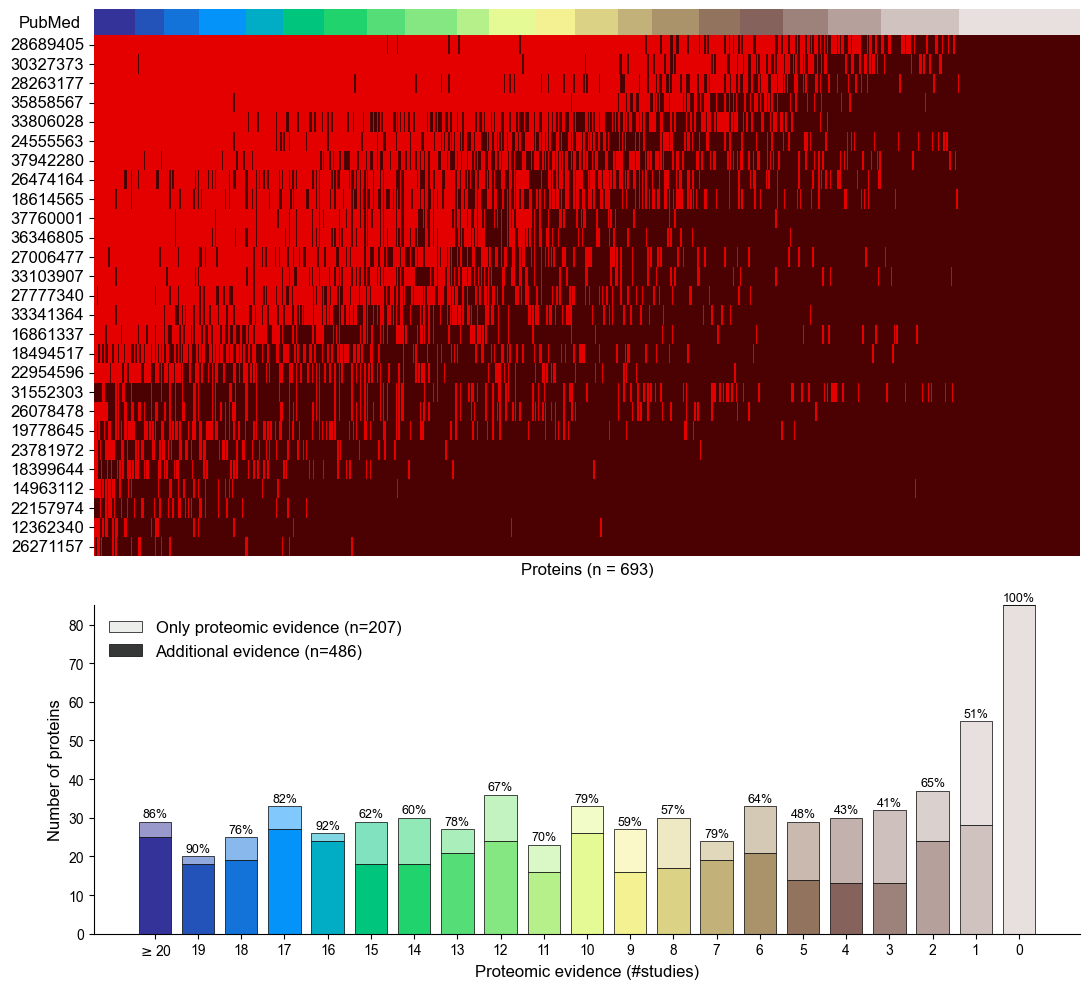

In [16]:
fig = mpl.figure.Figure(figsize=(11, 10))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1, 0.6])
sgs = mpl.gridspec.GridSpecFromSubplotSpec(2, 1, hspace=0, height_ratios=[0.05, 1], subplot_spec=gs[0])

has_additional_evidence_color, no_additional_evidence_color = (
    mpl.colors.to_rgba_array("xkcd:dark grey"),
    np.array([x/2 + 0.5 for x in mpl.colors.to_rgba_array("xkcd:light grey")]),
)


df_proteomic_cmap = df_model.sum()
df_proteomic_cmap = df_proteomic_cmap.apply(
    lambda x: x if x < max_count else max_count
)
df_proteomic_cmap = df_proteomic_cmap.apply(
    lambda x: x if x > min_count else min_count
)

# Add col colors (similar to seaborn)
cmap_dict = df_value_counts_colors["Colors"].to_dict()
cmap_segmented = mpl.colors.LinearSegmentedColormap.from_list(
    "legend",
    [cmap_dict[c] for c in df_value_counts_colors.index[::-1]],
    len(cmap_dict)
)

ax_nstudies_colors = sns.heatmap(
    np.array([df_proteomic_cmap.values]),
    ax=fig.add_subplot(sgs[0]),
    xticklabels=False,
    yticklabels=False,
    cmap=cmap_segmented,
    cbar=False,
)


ax_heatmap = sns.heatmap(
    df_model, 
    ax=fig.add_subplot(sgs[1]),
    cbar=False, 
    cmap=mpl.colors.ListedColormap(["xkcd:dried blood", "xkcd:red"]),
    xticklabels=False,
)
ax_heatmap.set_xlabel(f"Proteins (n = {len(df_model.columns)})", fontsize=fontsize)
ax_heatmap.yaxis.tick_left()
ax_heatmap.tick_params(axis='y', labelsize=fontsize)
ax_heatmap.set_ylabel("PubMed", ha="center", va="center", rotation=0, fontdict={"size": fontsize})
ax_heatmap.yaxis.set_label_coords(x=-0.045, y=1.025)
# ax_heatmap.set_xlabel(f"Model proteins (n = {len(df_model.columns)})", fontsize=fontsize+2)

# Barchart
ax_barchart = fig.add_subplot(gs[1])
sns.despine(ax=ax_barchart)
column_names = ["Additional evidence", "Only proteomic evidence"]
cmaps = dict(zip(column_names, [{}, {}]))

try:
    no_evidence = df_value_counts_colors.loc["0"]["Only proteomic evidence"]
except KeyError as e:
    no_evidence = 0

for key, color in df_value_counts_colors["Colors"].to_dict().items():
    cmaps["Additional evidence"][key] = color
    cmaps["Only proteomic evidence"][key] = [x/2 + 0.5 for x in color]
    if key == "0":
    #     cmaps["Additional evidence"][key] = has_additional_evidence_color
        cmaps["Only proteomic evidence"][key] = no_evidence_color

offset = np.zeros(len(df_value_counts_colors.index))
for idx, (label, series) in enumerate(df_value_counts_colors[column_names].items()):
    rects = ax_barchart.bar(
        list(series.index),
        list(series.values),
        bar_size, 
        label=label,
        color=[cmaps[label][c] for c in series.index],
        bottom=offset,
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += list(series.values)
    if idx == 1:
        labels = [
            f'{v1/v2 * 100:.0f}%' 
            for _, (v1, v2) in df_value_counts_colors[["Additional evidence", "Total"]].iterrows()
        ]
        ax_barchart.bar_label(rects, labels=labels, padding=1, fontsize=fontsize-3)
df_evidence_counts = df_value_counts_colors[column_names].sum(axis=0)
df_evidence_counts["Only proteomic evidence"] -= no_evidence 
handles = [
    mpl.patches.Patch(
        facecolor=facecolor, 
        label=f"{label} (n={n})", 
        edgecolor=edgecolor, 
        linewidth=edgewidth,
    )
    for label, n, facecolor in zip(
        column_names,
        df_evidence_counts.values,
        [has_additional_evidence_color, no_additional_evidence_color]
    )
]
if no_evidence != 0:
    df_evidence_counts["No evidence"] = no_evidence
    handles += [
        mpl.patches.Patch(
            facecolor=no_evidence_color,
            label=f"No evidence (n={no_evidence})",
            edgecolor=edgecolor,
            linewidth=edgewidth
        )
    ]
handles.reverse()
ax_barchart.legend(
    handles=handles, 
    ncol=1,
    loc="best", 
    # bbox_to_anchor=(0.5, 0., 0, 0), 
    frameon=False,
    fontsize=fontsize
)

ax_barchart.set_xlabel(df_value_counts_colors.index.name, fontsize=fontsize)
ax_barchart.set_ylabel(f"Number of proteins", fontsize=fontsize)
fig.tight_layout()
if save_figures:
    fig.savefig(
        f"{ROOT_PATH}{RESULTS_PATH}/proteomics/ModelProteomicEvidence_PanelAB.{imagetype}", 
        transparent=transparent, 
        format=imagetype
    )

fig

In [17]:
df_model_proteins_reordered.sum(axis=0).head()

Uniprot
P04406    25
P04040    24
P11142    23
P05089    22
P00915    22
dtype: int64